<!--Header-->
<div style="background-color: #fff; color: black">
<div style="padding-bottom: 20px; display: flex; justify-content: space-between; align-items: flex-start;">
<div style="width: 60%;">
<h1 style="margin: 16px">TFG - Inteligencia Artificial</h1>
<p style="margin: 16px; padding-bottom: 0">Junio de 2025</p>
</div>
<div style="width: 40%; text-align: right">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" alt="Logo UOC">
</div>
</div>
<h2 style="text-align: justify; padding: 0 16px">Aplicación de técnicas de IA fiable en la predicción del índice de calidad de vida en personas con tratamiento oncológico mediante aprendizaje automático.</h2>
<div style="background-color: #000; width: 100%; height: 2px; margin: 24px 0"></div>
<div style="padding: 20px">
<h4 style="margin: 0 0; padding: 0 0">Pablo Pimàs Verge</h4>
<h5 style="margin: 0 0; padding: 0 0">Grado en Ingeniería Informática</h5>
<h5 style="margin: 0 0 4px; padding: 0 0">Inteligencia Artificial</h5>
<h4 style="margin: 8px 0 4px; padding: 0 0">Dra. María Moreno de Castro</h4>
<h4 style="margin: 0 0; padding: 0 0">Dr. Friman Sanchéz</h4>
</div>
</div>

# Fase 2
#### Tercera Parte

## Explicabilidad del modelo

### Objetivos

### Índice

### Importaciones

In [1]:
# Importaciones de librerías básicas
import joblib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Importaciones de Scikit-learn 
from sklearn.metrics import mutual_info_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import FixedThresholdClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

# Librerías XAI
import shap
from lime import lime_tabular
import dice_ml as dice

# Funciones auxiliares
import aux_functions as afn

### Carga de los datos

In [2]:
X_train = pd.read_csv('./data/QLQ_C30_C23_X_train.csv')
X_test = pd.read_csv('./data/QLQ_C30_C23_X_test.csv')
X_cal = pd.read_csv('./data/QLQ_C30_C23_X_cal.csv')
y_train = pd.read_csv('./data/QLQ_C30_C23_y_train.csv').squeeze()
y_test = pd.read_csv('./data/QLQ_C30_C23_y_test.csv').squeeze()
y_cal = pd.read_csv('./data/QLQ_C30_C23_y_cal.csv').squeeze()

### Carga del modelo seleccionado

In [3]:
clf_model = joblib.load('./models/CatBoost_model.joblib')


## 1. Permutation feature importance

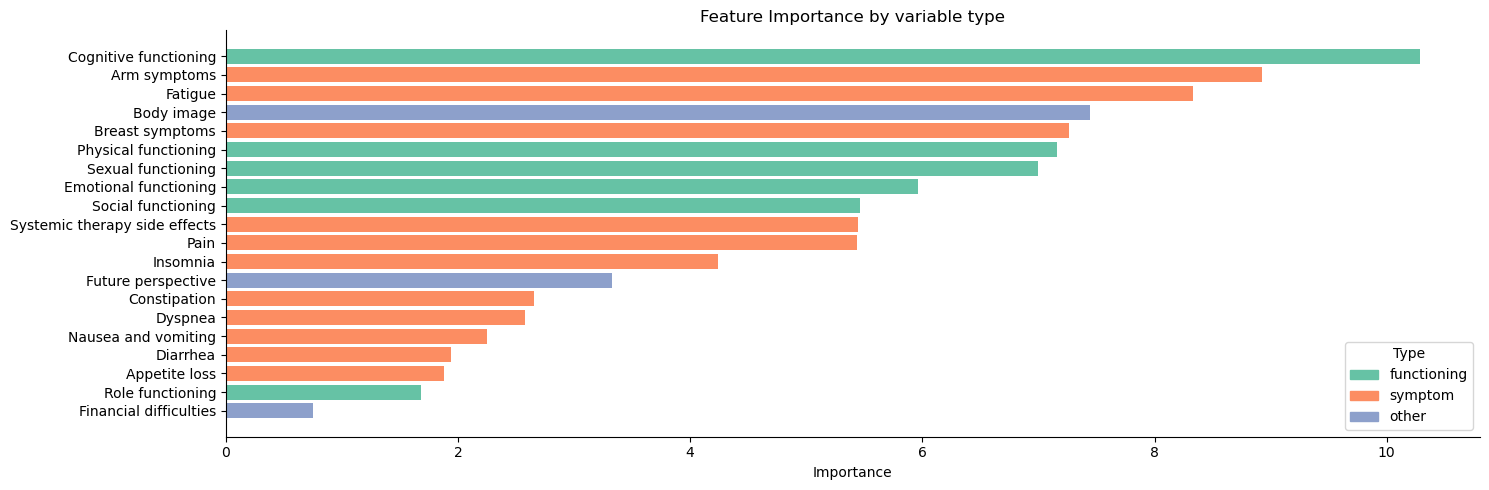

In [4]:
model_sorted_features_imp = sorted(
    zip(X_test.columns, clf_model.feature_importances_),
    key=lambda x: x[1]
)
model_imp_features, model_imp_sorted = zip(*model_sorted_features_imp)
afn.viz_feature_importance(model_sorted_features_imp)

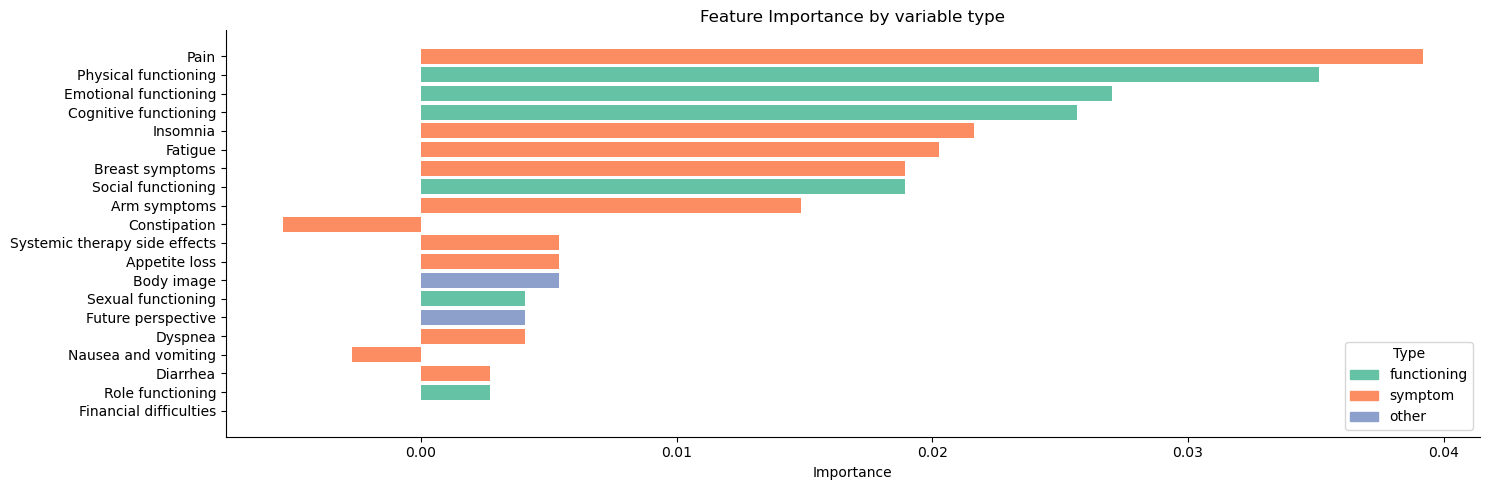

In [5]:
model_permutation_importance = permutation_importance(clf_model, X_test, y_test, random_state=73)
model_sorted_permutations = sorted(
    zip(X_test.columns, model_permutation_importance.importances_mean),
    key=lambda x: abs(x[1])
)
afn.viz_feature_importance(model_sorted_permutations)

In [6]:

# Calcular la importancia por permutación para train y test
permutation_train = permutation_importance(clf_model, X_train, y_train, random_state=23)
permutation_test = permutation_importance(clf_model, X_test, y_test, random_state=23)
sorted_index = permutation_train.importances_mean.argsort()
sorted_features = X_train.columns[sorted_index]
train_importances = pd.DataFrame(permutation_train.importances[sorted_index].T, columns=sorted_features)
test_importances = pd.DataFrame(permutation_test.importances[sorted_index].T, columns=sorted_features)

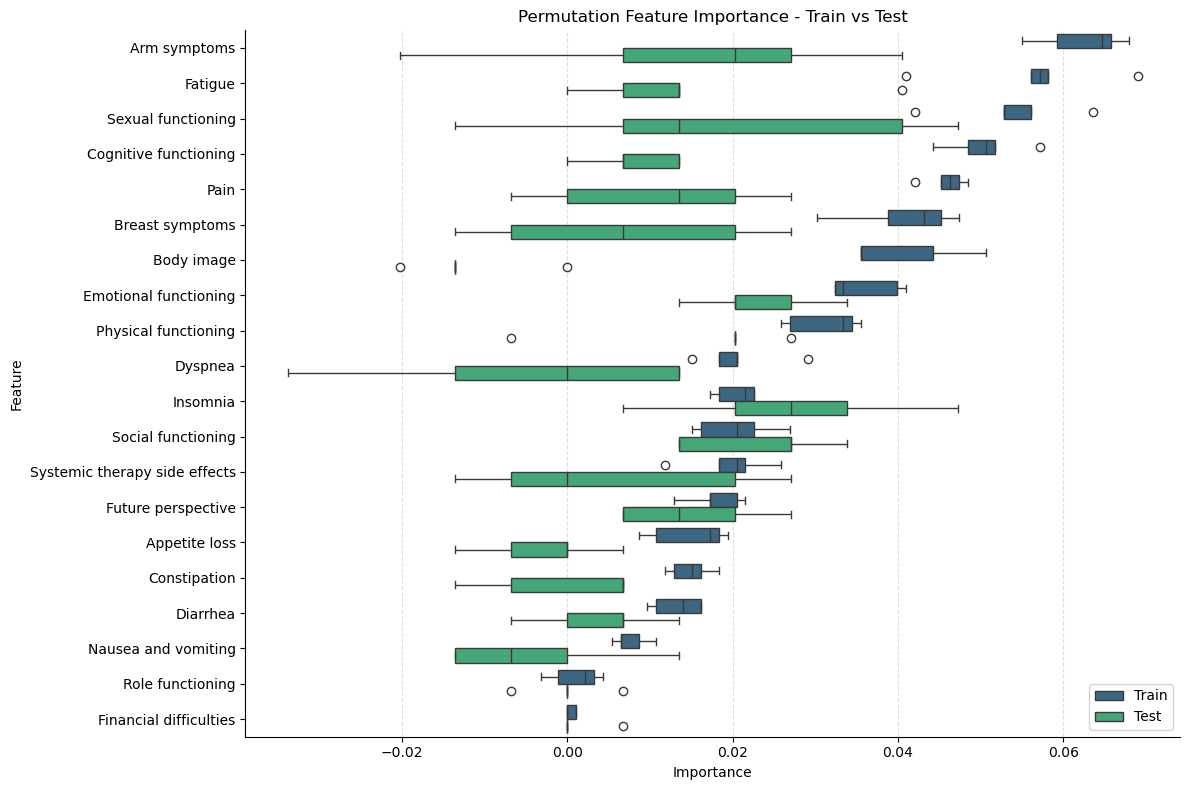

In [7]:
all_cols = train_importances.mean().abs().sort_values(ascending=False).index
train_long = train_importances[all_cols].melt(var_name='Feature', value_name='Importance')
train_long['Set'] = 'Train'
test_long = test_importances[all_cols].melt(var_name='Feature', value_name='Importance')
test_long['Set'] = 'Test'
combined = pd.concat([train_long, test_long], ignore_index=True)

plt.figure(figsize=(12, len(all_cols) * 0.4))  # Altura dinámica
sns.boxplot(data=combined, x='Importance', y='Feature', hue='Set', palette='viridis')
plt.title('Permutation Feature Importance - Train vs Test')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.legend(loc='lower right')
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
sns.despine()
plt.show()

## 2. Dependencia Parcial

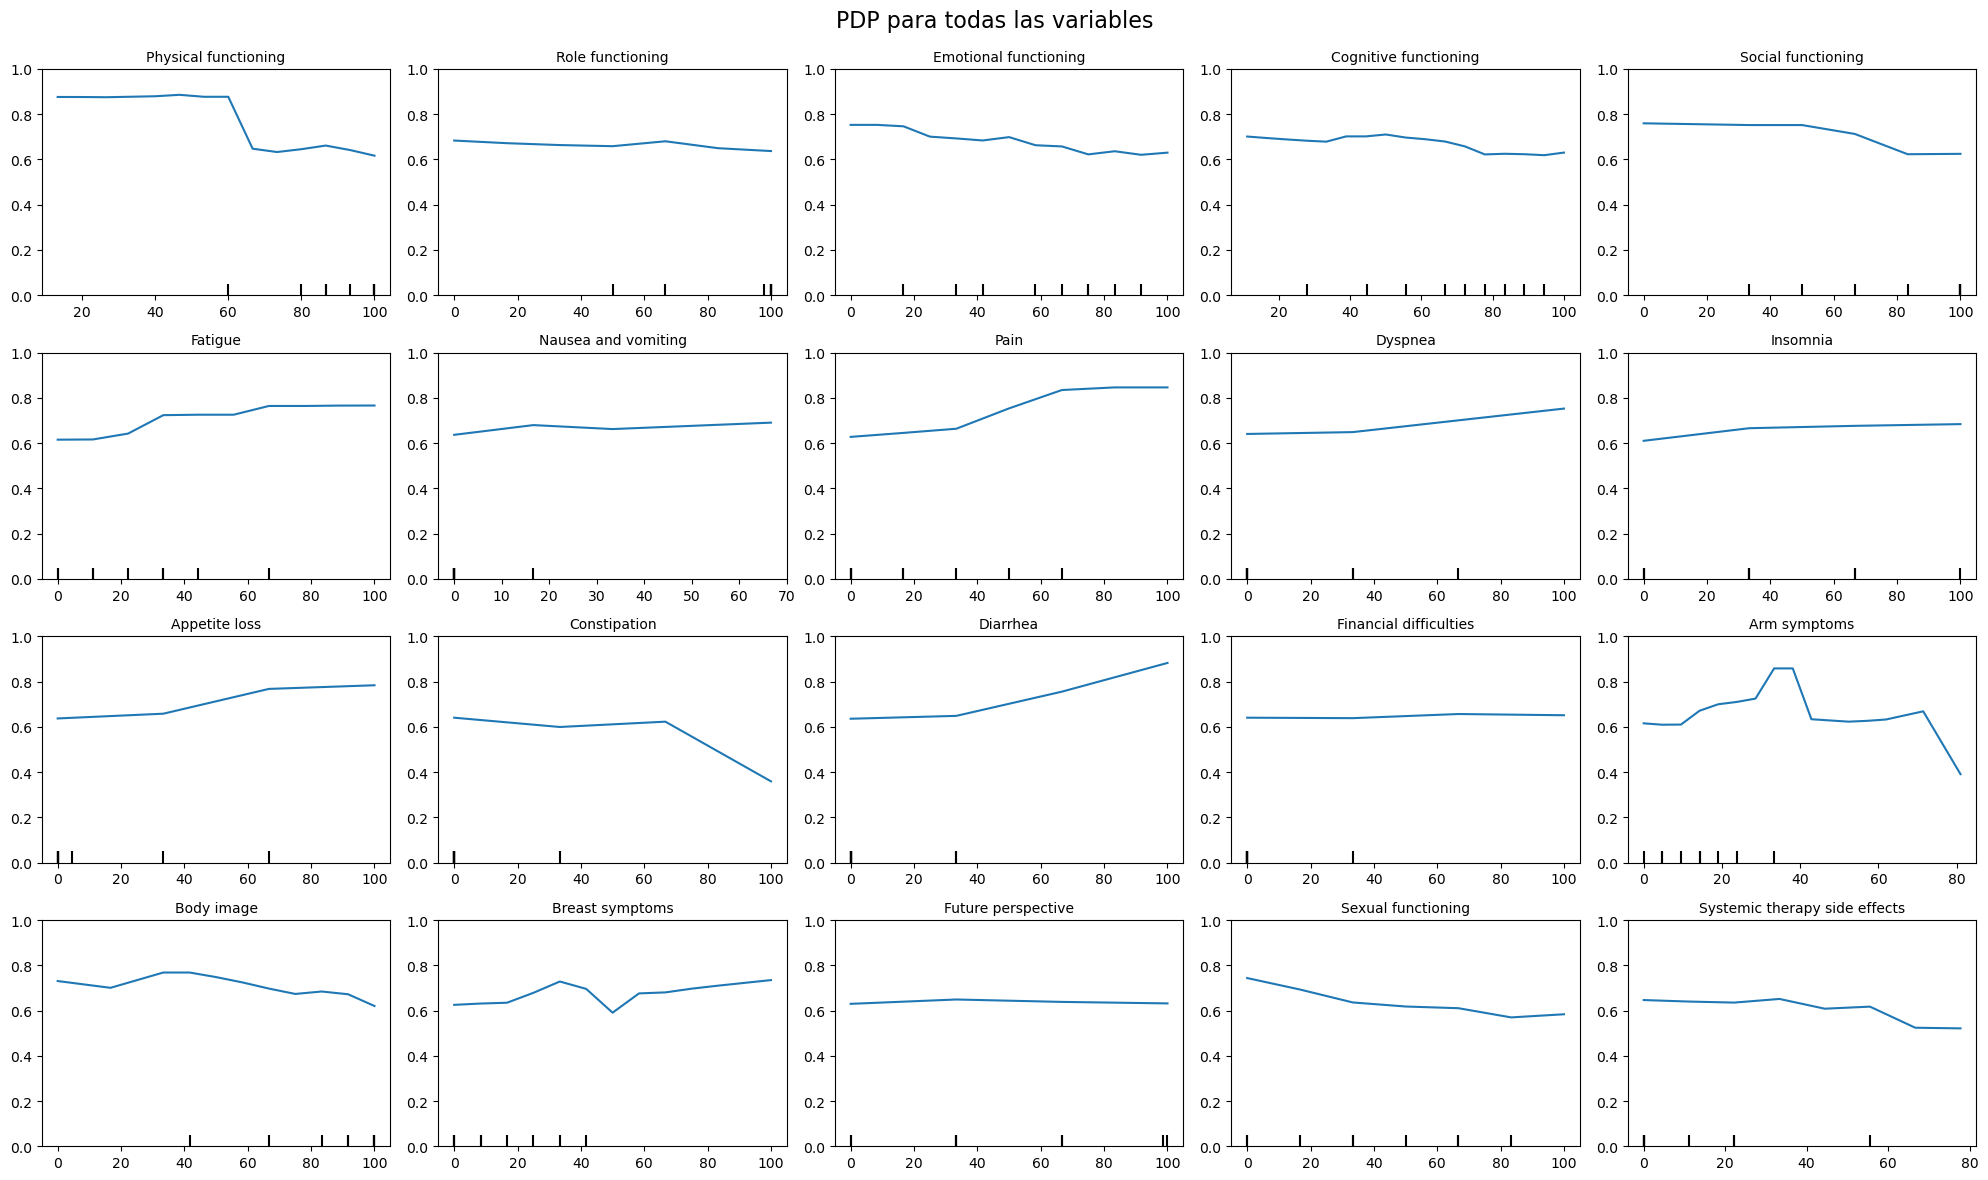

In [8]:
afn.viz_pdp_single(clf_model, X_test)


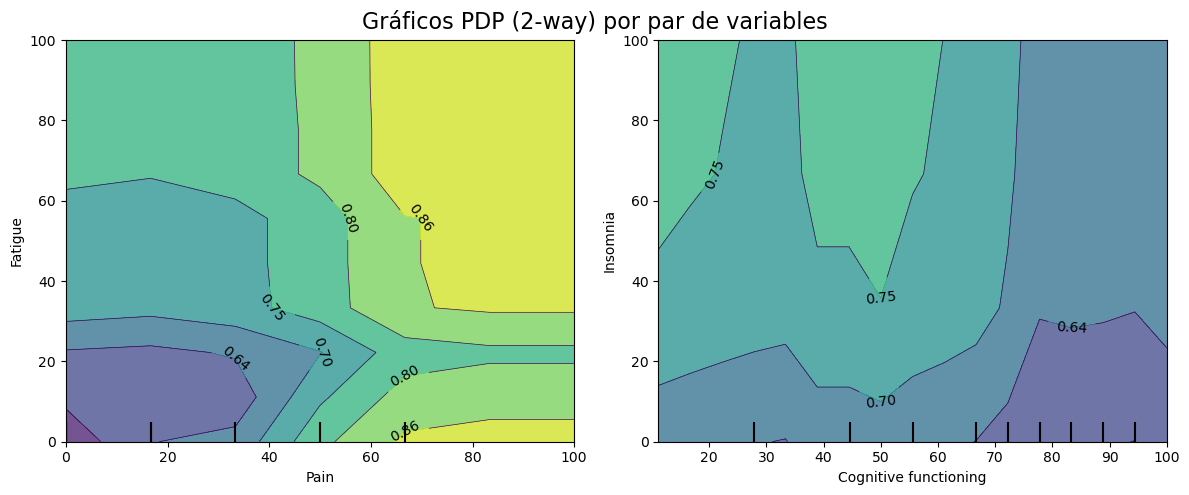

In [10]:
afn.viz_pdp_pairs(clf_model, X_test, [('Pain', 'Fatigue'), ('Cognitive functioning', 'Insomnia')])

## 3. Expectación Condicional Individual

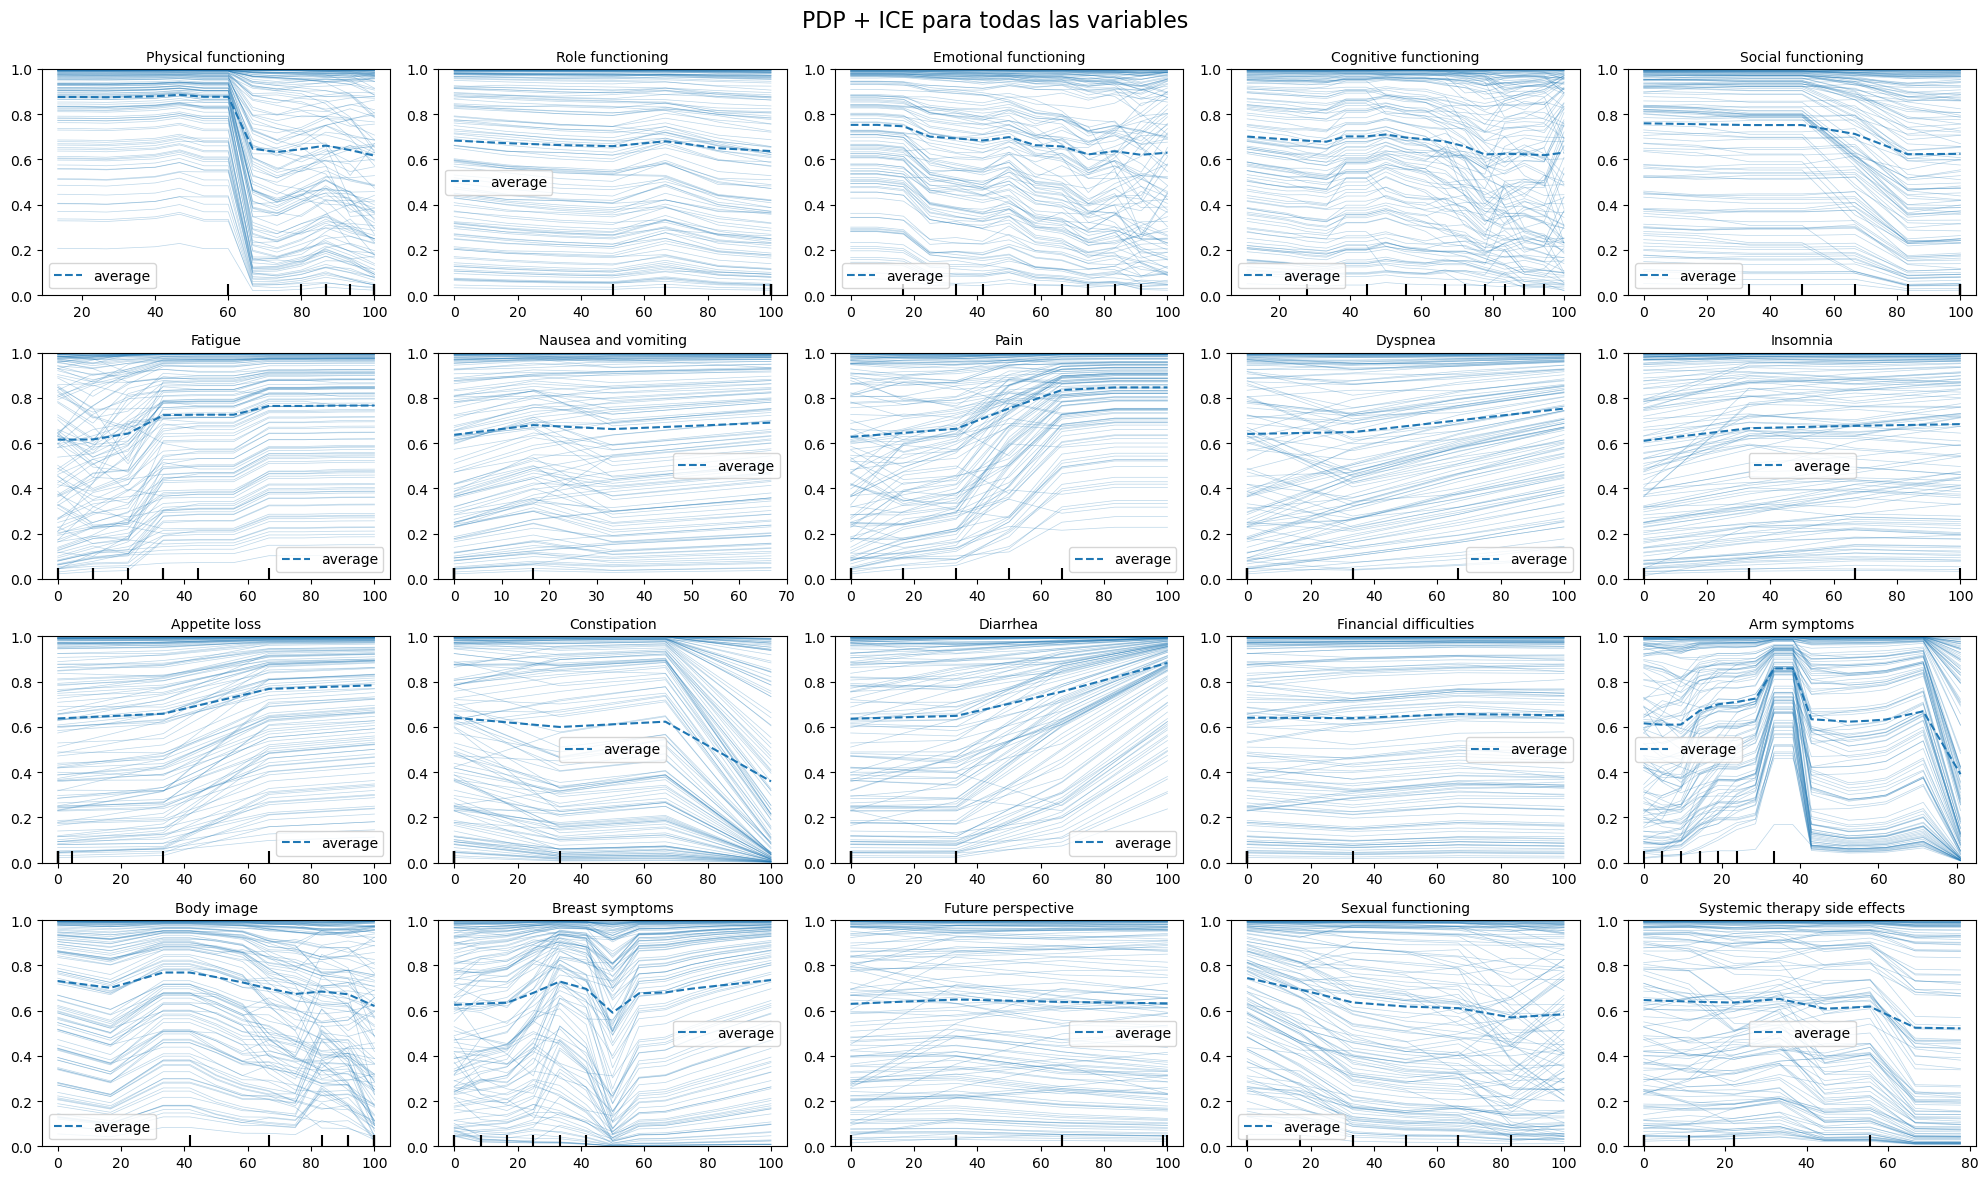

In [9]:
afn.viz_pdp_single(clf_model, X_test, kind='both')

## 4. LIME